# Hadamard layer for improve semantic segmentation

![image](results_celeba.png)

By Angello Hoyos, Mariano Rivera, august 2024

MIT Licence

## Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings('ignore')

In [2]:
import time
import datetime
import numpy as np
import numpy.random as rnd
import unet_segment as unet
import matplotlib.pyplot as plt


from glob import glob
from IPython import display
from skimage import transform
from scipy.linalg import hadamard 
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
print(tf.__version__, tf.executing_eagerly())

2.3.0 True


In [5]:
gpus = tf.config.list_physical_devices('GPU')

# Restrict TensorFlow to only use one GPU
try:
    if len(gpus) > 1:
        tf.config.set_visible_devices(gpus[1], 'GPU')

    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


## Load CelebA-HQ Dataset

[Dataset available here](https://www.kaggle.com/datasets/lamsimon/celebahq)

In [6]:
main_folder   = "/path/to/this/project/" 
dataset_folder   = "/path/to/CelebA-HQ"

INPUT_DIMS    = (256, 256, 3)
OUTPUT_DIMS   = (256, 256, 1)

NUM_CLASSES   = 19
CODES_SIZE    = 32
BATCH_SIZE    = 1

EPOCHS        = 1001
step_batch    = 100

save_imgs_folder = ''

with_codes   = True

# save_folder    = main_folder + '/celeba/unet_3plus/one_hot'
# gen_model_name = '/gen_one_hot_'
# dis_model_name = '/dis_one_hot_'

save_folder    = main_folder + '/celeba/unet_3plus/hadamard_test'
gen_model_name = '/gen_hadamard_'
dis_model_name = '/dis_hadamard_'

In [7]:
codes_matrix = hadamard(CODES_SIZE, dtype=np.float32)
codes_transpose = codes_matrix.transpose()

codes_tensor = tf.convert_to_tensor(codes_matrix)
codes_transpose = tf.convert_to_tensor(codes_transpose)

identity_matrix = np.identity(NUM_CLASSES)
identity_matrix = tf.convert_to_tensor(identity_matrix)

In [8]:
def CreateDataset(main_path, img_path='CelebA-HQ-img', mask_path='CelebA-HQ-mask', batch_size=1):
    ''' Train data '''
    xfiles_train  = glob(os.path.join(main_path, img_path,  'train', '*.jpg'))
    yfiles_train  = glob(os.path.join(main_path, mask_path, 'train', '*.png'))
    
    xfiles_train.sort() 
    yfiles_train.sort()
    
    train_x = tf.data.Dataset.list_files(xfiles_train, shuffle=False)
    train_y = tf.data.Dataset.list_files(yfiles_train, shuffle=False)
    
    train_xy = tf.data.Dataset.zip((train_x, train_y))
    
    train_xy = train_xy.cache(save_folder + '/cache.txt').shuffle(buffer_size=len(xfiles_train), reshuffle_each_iteration=True)
    train_xy = train_xy.map(ReadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_xy = train_xy.batch(batch_size)
    train_xy = train_xy.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return train_xy

In [9]:
@tf.function
def ReadImages(xfile, yfile, augment=True):
    xim = tf.io.read_file(xfile)
    xim = tf.io.decode_jpeg(xim)
    xim = tf.image.resize(xim, INPUT_DIMS[:2], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)                            
    
    yim = tf.io.read_file(yfile)
    yim = tf.io.decode_jpeg(yim)
    yim = tf.image.resize(yim, INPUT_DIMS[:2], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    xim = tf.cast(xim, tf.float32)
    xim = xim/127.5-1 
    
    yim = tf.cast(yim, tf.int32)
    yim = yim//10
    
    if with_codes:
        yim_codes = tf.gather(codes_tensor, yim)
        yim_codes = tf.squeeze(yim_codes)
    else:
        yim = tf.cast(yim, tf.float32)
        return xim, yim 
        
    yim = tf.cast(yim, tf.float32)
    yim_codes = tf.cast(yim_codes, tf.float32)

    return xim, yim, yim_codes

## Pix2Pix type Models

### Encoders

In [10]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result
    

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters,  size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    
    return result

In [12]:
class MaskSoftargmax(tf.keras.layers.Layer):
    def __init__(self, numclasses):
        super(MaskSoftargmax, self).__init__()
        colormap = np.array(range(numclasses)) #/(NUM_CLASSES-1))-0.5)*2
        colormap = tf.constant(colormap,  dtype=tf.float32)
        self.colormap = tf.reshape(colormap, [1, 1, 1, numclasses])
        
    def call(self, inputs):
        if with_codes:
            inputs = tf.einsum('bmni, ij->bmnj', inputs, codes_transpose)
        elif with_fourier:
            inputs = tf.cast(inputs, tf.complex64)
            inputs = tf.math.real(tf.signal.ifft(inputs))
            inputs = tf.cast(inputs, tf.float32)
        
        alpha = tf.keras.layers.Softmax()(inputs)
        index = tf.keras.layers.Lambda(lambda alpha: alpha*self.colormap)(alpha)
        mask  = tf.keras.backend.sum(index, axis=-1, keepdims=True)    
        
        # print(mask.shape, alpha.shape, inputs.shape)
        
        return mask, alpha, inputs

In [14]:
def GeneratorUNet(num_classes):
    x_inputs = tf.keras.layers.Input(shape=INPUT_DIMS)

    down_stack = [downsample(64,  4, apply_batchnorm=False), 
                  downsample(128, 4),  
                  downsample(256, 4),  
                  downsample(512, 4),  
                  downsample(512, 4),  
                  downsample(512, 4),  
                  downsample(512, 4),  
                  downsample(512, 4)]  

    up_stack   = [upsample(512, 4, apply_dropout=True),  
                  upsample(512, 4, apply_dropout=True),  
                  upsample(512, 4, apply_dropout=True), 
                  upsample(512, 4),  
                  upsample(256, 4),  
                  upsample(128, 4),  
                  upsample(64,  4)]  


    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(num_classes, 4,
                                           strides=2,
                                           padding='same',
                                           activation='tanh',
                                           kernel_initializer=initializer)

    x = x_inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    
    mask, alpha, codes = MaskSoftargmax(num_classes)(x)
    
    return tf.keras.Model(inputs=x_inputs, outputs=[mask, alpha, codes])

In [17]:
def GeneratorResUNet(num_classes, resunet=True):
    filters_per_block = np.array([32, 64, 128, 128, 256])
    
    if resunet:
        resunet = unet.resunet(filters_per_block = filters_per_block,  
                              output_channels    = num_classes,
                              img_size           = INPUT_DIMS,
                              droprate           = 0.25) 
    else:
        resunet = unet.incepresunet_segment(filters_per_block = filters_per_block,  
                                            num_classes       = num_classes,
                                            img_size          = INPUT_DIMS,
                                            droprate          = 0.25)  
                    

    initializer = tf.random_normal_initializer(0., 0.02)

    convT = tf.keras.layers.Conv2DTranspose(num_classes, 4,
                                            strides = 1,
                                            padding = 'same',
                                            activation='tanh',
                                            kernel_initializer = initializer)

    
    x_input = tf.keras.layers.Input(shape=INPUT_DIMS)
    
    x = x_input
    x = resunet(x)
    x = convT(x)
    
    mask, alpha, codes = MaskSoftargmax(num_classes)(x)
    
    return tf.keras.Model(inputs=x_input, outputs=[mask, alpha, codes])

In [18]:
def Generator_UNet3Plus(num_classes):
    '''
    Usamos nuestra versión ResUnet como generador
    '''
    filters_per_block = np.array([64, 128, 256, 512, 1024])
    
    unet_3plus = unet.unet_3plus_segment(filters_per_block = filters_per_block,  
                                         num_classes       = num_classes,
                                         img_size          = INPUT_DIMS) 
                    

    initializer = tf.random_normal_initializer(0., 0.02)

    convT = tf.keras.layers.Conv2DTranspose(num_classes, 4,
                                            strides = 1,
                                            padding = 'same',
                                            activation='tanh',
                                            kernel_initializer = initializer)

    
    x_input = tf.keras.layers.Input(shape=INPUT_DIMS)
    
    x = x_input
    x = unet_3plus(x)
    x = convT(x)
    
    mask, alpha, codes = MaskSoftargmax(num_classes)(x)
    
    return tf.keras.Model(inputs=x_input, outputs=[mask, alpha, codes])

### Discriminador

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=INPUT_DIMS,  name='input_image')
    tar = tf.keras.layers.Input(shape=OUTPUT_DIMS, name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels+1)

    down1 = downsample(64,  4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)     # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)     # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)      # (batch_size, 32, 32, 128)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (batch_size, 30, 30, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 17, 17, 512)
    last = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 14,14, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

## Loss function 

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss        = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss   = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss  = real_loss + generated_loss
    return total_disc_loss

In [21]:
LAMBDA = [1, 1000, 100, 250]

def generator_loss(disc_generated_output, gen_map, gen_prob, target, gen_codes=None, target_codes=None):
#     l1_codes_loss = 0 
    mse_codes_loss = 0
    
    # Entropia cruzada a partir de logits del discriminador
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # MAE reconstrucción en generador
    l1_loss = tf.reduce_mean(tf.abs(target - gen_prob))
    # Entropia cruzada a partir de logits del generador
    ce_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(target, gen_prob))   
    # Gini (entropy) penalty
    gn_loss = -tf.reduce_mean(tf.square(gen_prob))
    
    # Suma de los componentes del error
    total_loss = gan_loss + LAMBDA[0]*l1_loss + LAMBDA[1]*ce_loss + LAMBDA[2]*gn_loss 
    
    if gen_codes != None:
#         l1_codes_loss = tf.reduce_mean(tf.abs(target_codes - gen_codes))
        mse_codes_loss = loss_mse(target_codes, gen_codes)
        
        total_loss += LAMBDA[3]*mse_codes_loss
    
    return total_loss, gan_loss, l1_loss, ce_loss, mse_codes_loss

In [22]:
def GenerateImages(model, x_input, y_input, save_path, filename):
    colors_01 = [(  0/255,   0/255,   0/255), #Background
                 (255/255,   0/255,   0/255), #Face   
                 (255/255, 153/255,  51/255), #Neck
                 (204/255, 204/255,   0/255), #Glasses
                 (102/255,  50/255,   0/255), #L-ear
                 (255/255,   0/255,   0/255), #R-ear
                 (102/255, 204/255,   0/255), #Mouth
                 ( 76/255, 153/255,   0/255), #Nose
                 (255/255, 255/255,   0/255), #U-Lip
                 (  0/255,   0/255, 153/255), #L-Lip
                 ( 50/255, 255/255, 255/255), #R-Brow
                 (  0/255, 255/255, 255/255), #L-Brow
                 ( 55/255,  49/255, 247/255), #L-Eye 
                 (204/255,   0/255, 204/255), #R-Eye
                 (  0/255, 204/255,   0/255), #Clothes
                 (  0/255,   0/255, 204/255), #Hair
                 (  0/255, 204/255, 204/255), #Earrings
                 (  0/255,  50/255,   0/255), #Necklace
                 (255/255,  51/255, 155/255)] #Hat
    
    seg_cmap = LinearSegmentedColormap.from_list('seg_colors', colors_01)
    
    # con training=True se obtienen las metricas sobre el Lote. 
    # En otro caso, no se evaluan y se regresan las del entrenamiento.
    y_pred, probs, __ = model(x_input, training=True)  
    plt.figure(figsize=(18, 5))
    display_list = [ y_input[0], x_input[0], y_pred[0], probs[0]]

    plt.subplot(1, 4, 1)
    im = display_list[1]
    m, M = tf.reduce_min(im).numpy(), tf.reduce_max(im).numpy()
    im = (im-m)/(M-m)
    plt.imshow(im) 
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    img = display_list[0]
    plt.imshow(img, cmap=seg_cmap, interpolation='nearest', vmin=0, vmax=18) 
    plt.axis('off')

    plt.subplot(1, 4, 3)
    mask = np.argmax(display_list[3], axis=-1)         
    plt.imshow(mask, cmap=seg_cmap, interpolation='nearest', vmin=0, vmax=18)   
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(im)
    plt.imshow(mask, cmap=seg_cmap, alpha=.5, interpolation='nearest', vmin=0, vmax=18)
    plt.axis('off')
    
    # plt.show()
    plt.tight_layout()
    plt.savefig(save_path + filename)
    return

## Custom Train Step 

In [23]:
@tf.function
def train_step(input_image, target, step, generator, discriminator, generator_optimizer, discriminator_optimizer, summary_writer, target_codes=None):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_map, gen_prob, gen_codes = generator(input_image, training=True)
        
        disc_real_output             = discriminator([input_image, target],  training=True)
        disc_generated_output        = discriminator([input_image, gen_map], training=True)
        
        if target_codes != None:
            gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ce_loss, gen_l1_codes_loss = generator_loss(disc_generated_output, gen_map, gen_prob, target, gen_codes, target_codes)
        else:
            gen_total_loss, gen_gan_loss, gen_l1_loss, gen_ce_loss, gen_l1_codes_loss = generator_loss(disc_generated_output, gen_map, gen_prob, target)
        
        disc_loss  = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients     = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,     discriminator.trainable_variables)

    generator_optimizer.apply_gradients    (zip(generator_gradients,     generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss',    gen_total_loss,    step=step//step_batch)
        tf.summary.scalar('gen_gan_loss',      gen_gan_loss,      step=step//step_batch)
        tf.summary.scalar('gen_l1_loss',       gen_l1_loss,       step=step//step_batch)
        tf.summary.scalar('gen_ce_loss',       gen_ce_loss,       step=step//step_batch)
        tf.summary.scalar('gen_l1_codes_loss', gen_l1_codes_loss, step=step//step_batch)
        tf.summary.scalar('disc_loss',         disc_loss,         step=step//step_batch)
        
    return gen_ce_loss, gen_total_loss, disc_loss
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [24]:
def fit(train_xy, steps, generator, discriminator, generator_optimizer, discriminator_optimizer, summary_writer, save_imgs_folder):
    start = time.time()
    best_model_loss = float('inf')
    
    if with_codes or with_fourier:
        for step, (x, y, z) in train_xy.repeat().take(steps).enumerate():
            gen_ce_loss, gen_total_loss, disc_loss = train_step(x, y, step, generator, discriminator, generator_optimizer, discriminator_optimizer, summary_writer, z)
            
            if gen_total_loss < best_model_loss:
                generator.save_weights(save_folder + '/best_' + gen_model_name[1:] + str(i).zfill(2) +'.h5')
                best_model_loss = gen_total_loss
            
            if (step) % step_batch == 0:
                display.clear_output(wait=True)
                GenerateImages(generator, x, y, save_imgs_folder, str(int(step)).zfill(5)+'.png')
                print(f'\nTime for {step_batch} steps: {time.time()-start:.2f} sec \t CE Loss: {gen_ce_loss} \t Gen Loss: {gen_total_loss} \t Dis Loss: {disc_loss}\n')    
                start = time.time()
                print(f"Step: {step//step_batch}")
                
            if (step+1) % (step_batch//10) == 0: 
                print('.', end='', flush=True)
    else:
        for step, (x, y) in train_xy.repeat().take(steps).enumerate():
            gen_ce_loss, gen_total_loss, disc_loss = train_step(x, y, step, generator, discriminator, generator_optimizer, discriminator_optimizer, summary_writer)
            
            if gen_total_loss < best_model_loss:
                generator.save_weights(save_folder + '/best_' + gen_model_name[1:] + str(i+1).zfill(2) +'.h5')
                best_model_loss = gen_total_loss
            
            if (step) % step_batch == 0:
                display.clear_output(wait=True)
                GenerateImages(generator, x, y, save_imgs_folder, str(int(step)).zfill(5)+'.png')
                print(f'\nTime for {step_batch} steps: {time.time()-start:.2f} sec \t CE Loss: {gen_ce_loss} \t Gen Loss: {gen_total_loss} \t Dis Loss: {disc_loss}\n')
                start = time.time()
                print(f"Step: {step//step_batch}")
                
            if (step+1) % (step_batch//10) == 0: 
                print('.', end='', flush=True)
                
                
    return best_model_loss

## Main training environment & results 


Time for 100 steps: 37.85 sec 	 CE Loss: 0.271177738904953 	 Gen Loss: 610.3343505859375 	 Dis Loss: 0.014511169865727425

Step: 10
01: 392.4221794605255 total sec 		 with best loss at 535.4881591796875


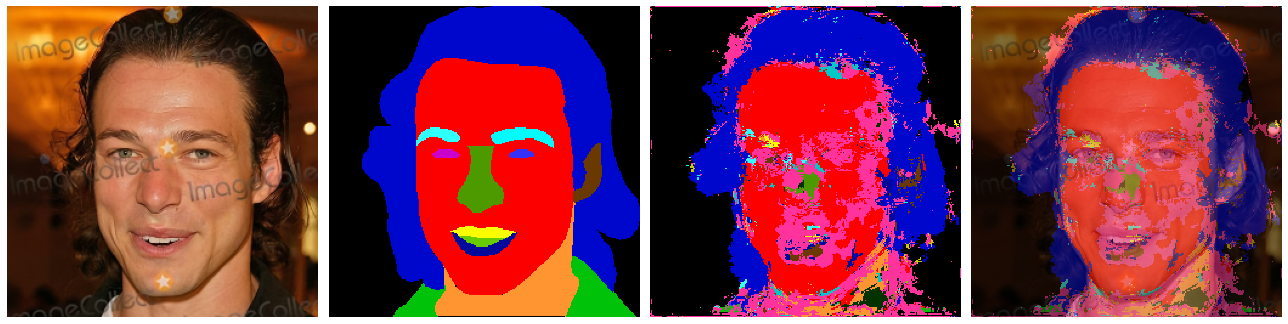

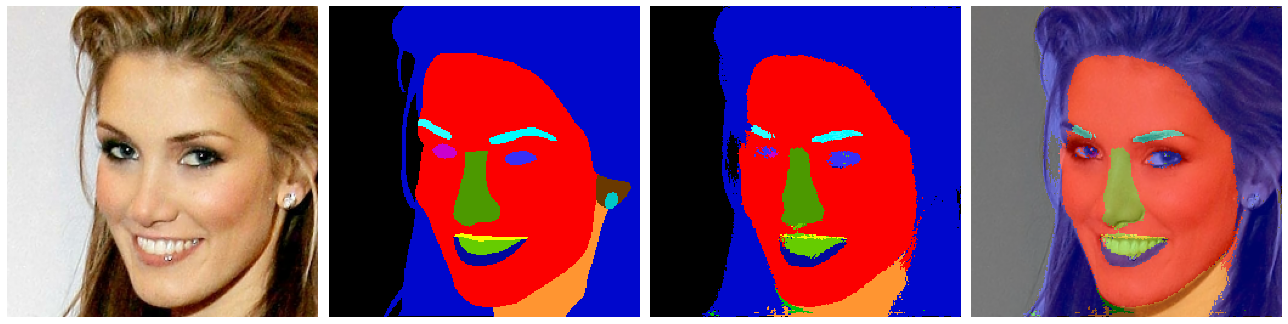

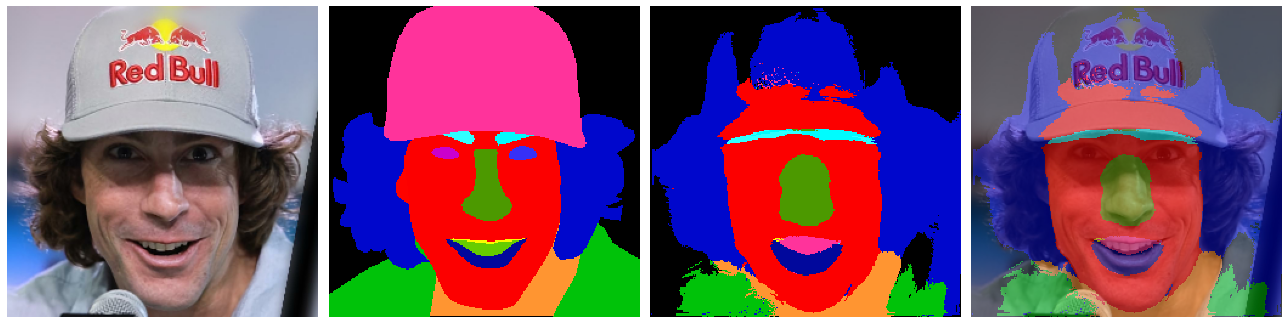

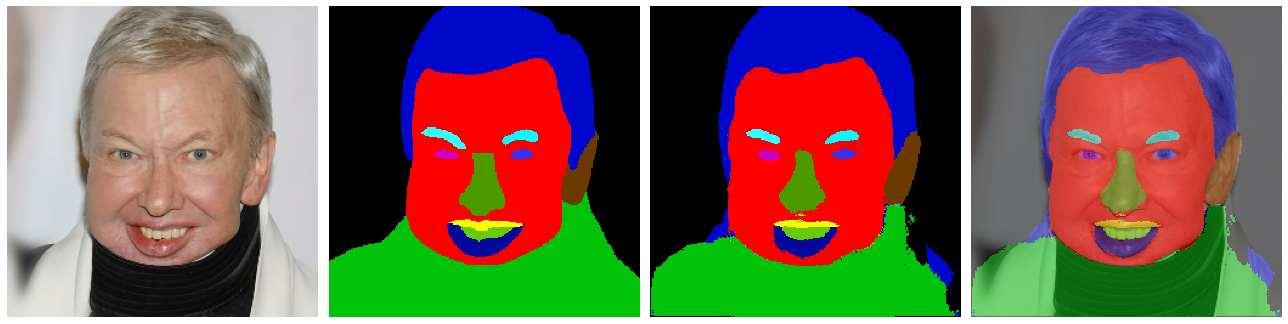

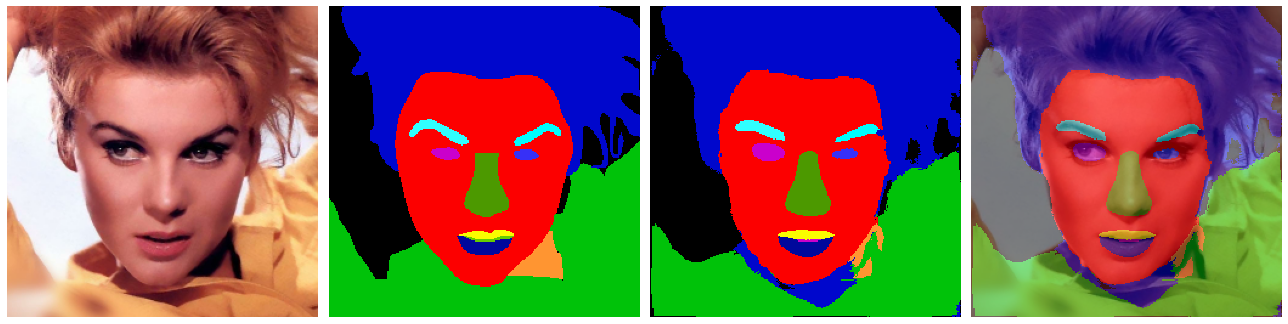

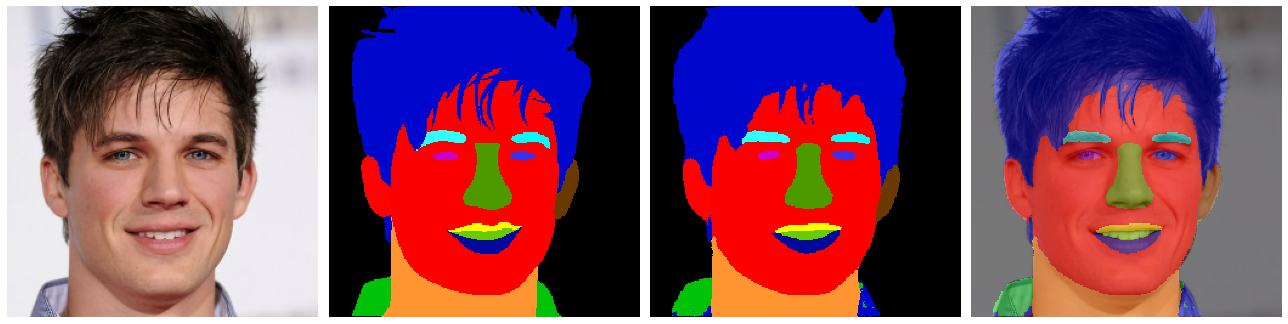

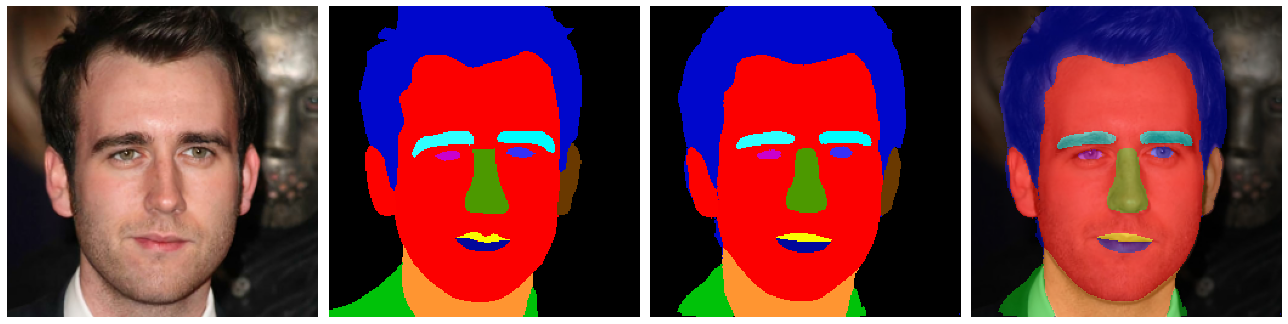

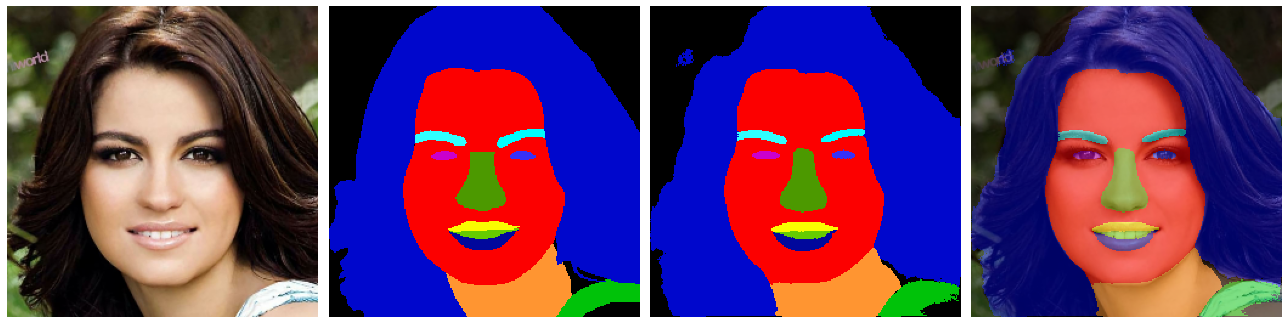

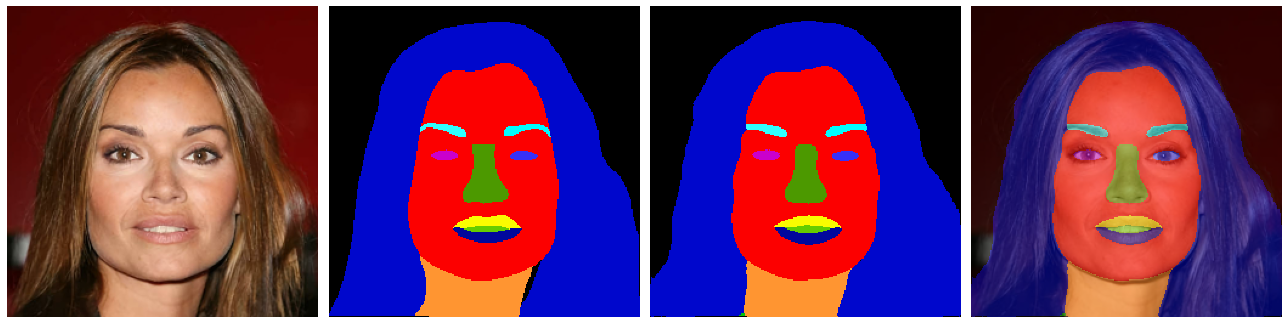

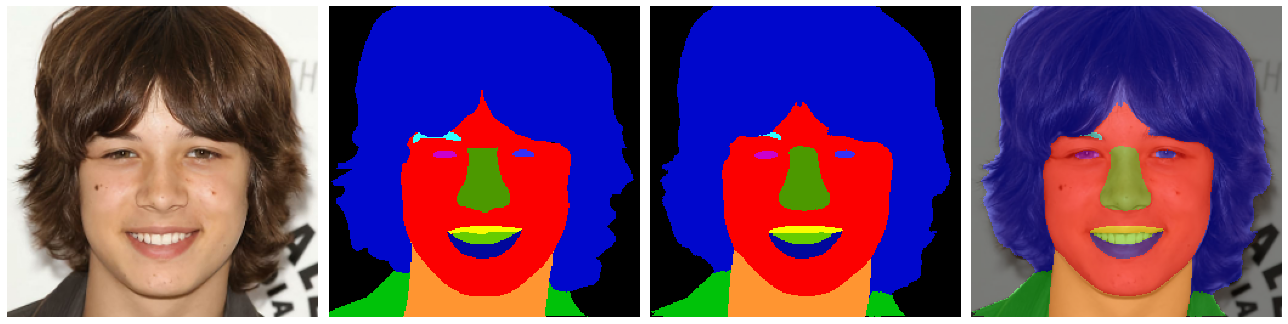

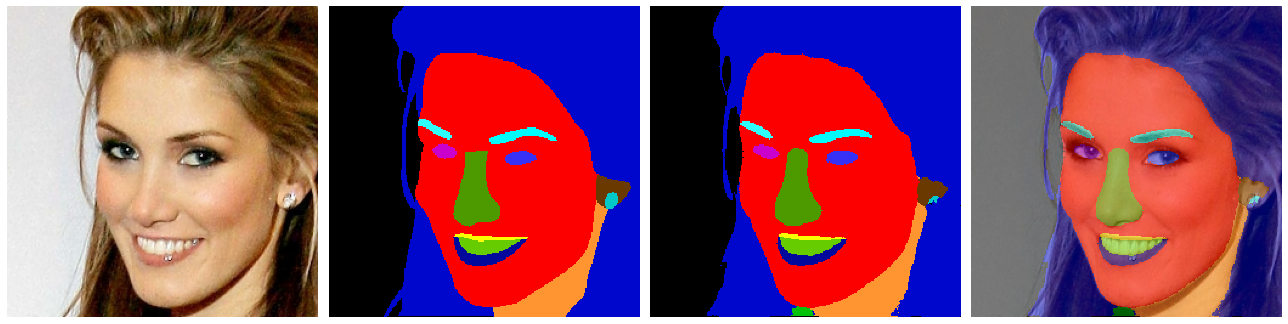

In [25]:
i = 1
save_imgs_folder = save_folder + '/imgs_01/'

if not os.path.exists(save_imgs_folder):
    os.mkdir(save_imgs_folder)

train_xy = CreateDataset(dataset_folder)
print('Dataset created!')

if with_codes:
    generator = Generator_UNet3Plus(CODES_SIZE)
else:
    generator = GeneratorUNet3Plus(NUM_CLASSES)

discriminator = Discriminator()
print('Models created!')

generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

for var in generator_optimizer.variables():
    var.assign(tf.zeros_like(var))

for var in discriminator_optimizer.variables():
    var.assign(tf.zeros_like(var))

summary_writer = tf.summary.create_file_writer(save_folder + "/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

start = time.time()
best_model_loss = fit(train_xy, EPOCHS, generator, discriminator, generator_optimizer, discriminator_optimizer, summary_writer, save_imgs_folder)
print(f'{str(i).zfill(2)}: {time.time()-start} total sec \t\t with best loss at {best_model_loss}')

generator.save_weights(save_folder + gen_model_name + str(i).zfill(2) +'.h5')
discriminator.save_weights(save_folder + dis_model_name + str(i).zfill(2) +'.h5')